In [1]:
import urllib , xmltodict , time 
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from matplotlib import animation
import pandas_datareader.data as web
from tqdm import tqdm

import common

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib notebook

In [4]:

path_to_csv = '~/treasure_yields.csv'

def _get_data(mode='new'):

    if mode =='local':
        print('Loading data from local ...')
        df = pd.read_csv(path_to_csv,index_col=0)
        df.index = pd.to_datetime(df.index)
    else:
        if mode=='new':
            url = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=month(NEW_DATE)%20eq%203%20and%20year(NEW_DATE)%20eq%202019'
        elif mode == 'all':
            url = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData'
        else:
            raise("wrong mode parameter")
        file = urllib.request.urlopen(url)
        data = file.read()
        file.close()
        f = xmltodict.parse(data)
        dd = {}
        for i in range(len(f['feed']['entry'])):
            slice_ = f['feed']['entry'][i]['content']['m:properties']
            keys = list(slice_.keys())
            try:
                date = slice_['d:NEW_DATE']['#text']
            except KeyError:
                data = None
            values_ = []
            for key in keys[2:]:
                try:
                    value = slice_[key]['#text']
                except KeyError:
                    value = None
                values_.append(value)
            dd[date] = values_

        df = pd.DataFrame.from_dict(dd,orient='index')
        df.columns = [key.split('d:')[1] for key in keys[2:]]
        print('saving to csv ...')
        df.reset_index().to_csv(path_to_csv)
    return df

_get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

In [20]:
today = dt.datetime.today().strftime('%Y-%m-%d')
start = '2019-01-01'
end = today#'2019-03-28'



tres_init = _get_data(mode='all')
snp500 = _get_px('SPY')
snp500.name = 'snp500'

tresdf = tres_init[['BC_3MONTH','BC_5YEAR','BC_10YEAR']].astype(float)
#tresdf.index = [x.split('T')[0] for x in tresdf.index]
print('DF retrieved : ',tresdf.shape)
tresdf.head()

saving to csv ...
DF retrieved :  (7352, 3)


,BC_3MONTH,BC_5YEAR,BC_10YEAR
1997-01-02T00:00:00,5.19,6.30,6.54
1996-12-31T00:00:00,5.21,6.21,6.43
1997-01-03T00:00:00,5.17,6.28,6.52
1997-01-07T00:00:00,5.16,6.32,6.57
1997-01-06T00:00:00,5.17,6.30,6.54


In [21]:

curve_params , curve_data = common._fit_poly(tresdf.iloc[-(365)*3:]
                                     )
#curve_params.head()

Solving polynomials ...


100%|██████████| 4380/4380 [00:35<00:00, 92.98it/s] 


In [22]:
 tresdf['5y3m_spread'] = tresdf['BC_5YEAR'] - tresdf['BC_3MONTH'] 

curve_data_t = curve_data.T.reset_index(drop=True)

poly_coef = curve_params.drop(columns=['c'])
poly_coef = poly_coef * 1e2
poly_coef_vs_snp500 = poly_coef.join(snp500,how='inner')
tresdf_vs_snp500 = tresdf.join(snp500,how='inner')

#poly_coef_vs_snp500['coef_multy'] = poly_coef_vs_snp500
poly_coef_vs_snp500['coef2'] = np.log(np.exp(np.abs(np.exp(poly_coef_vs_snp500.pow3.diff()))) *100)

<IPython.core.display.Javascript object>


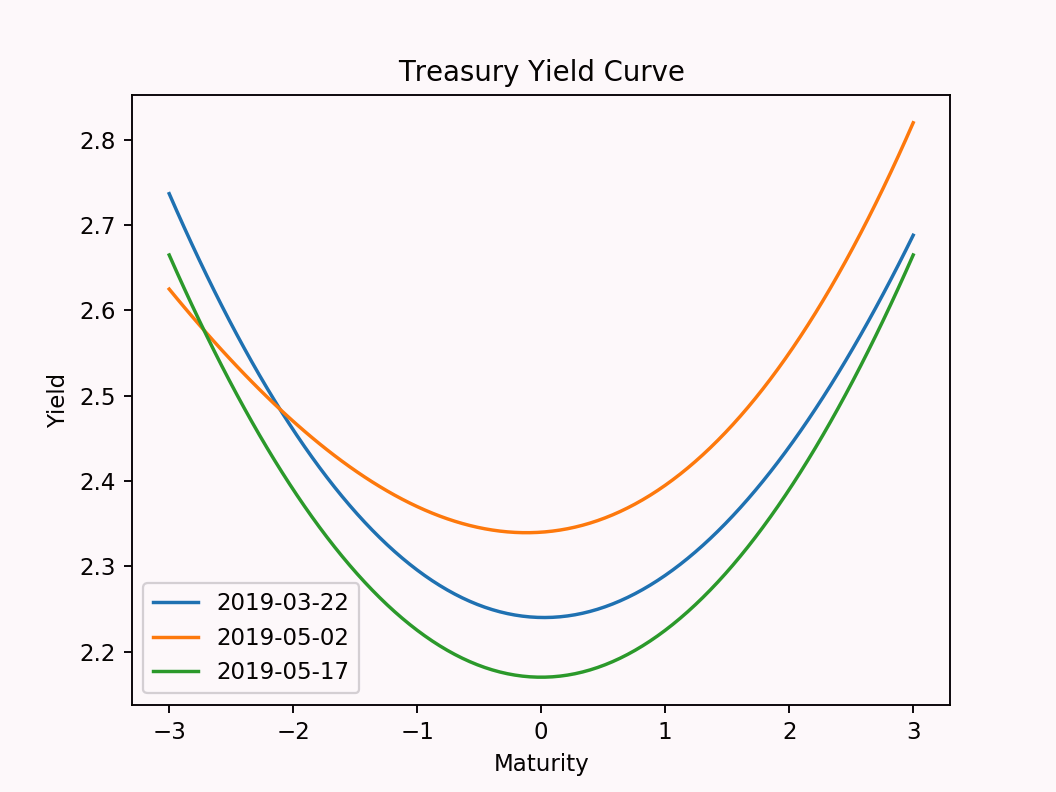

Text(0,0.5,'Yield')

In [29]:
#fig = plt.figure()

#ax = curve_data[['2019-03-22','2019-05-02',today]].plot(title='Treasury Yield Curve')
ax = curve_data[['2019-03-22','2019-05-02','2019-05-17']].plot(title='Treasury Yield Curve')

ax.set_xlabel("Maturity")
ax.set_ylabel('Yield')

In [30]:
common.plot_multi(poly_coef_vs_snp500[['coef','coef2']],title='Slope Coef. vs cust_index',loc='center r', figsize=(10, 5))

KeyError: "['coef'] not in index"

<IPython.core.display.Javascript object>


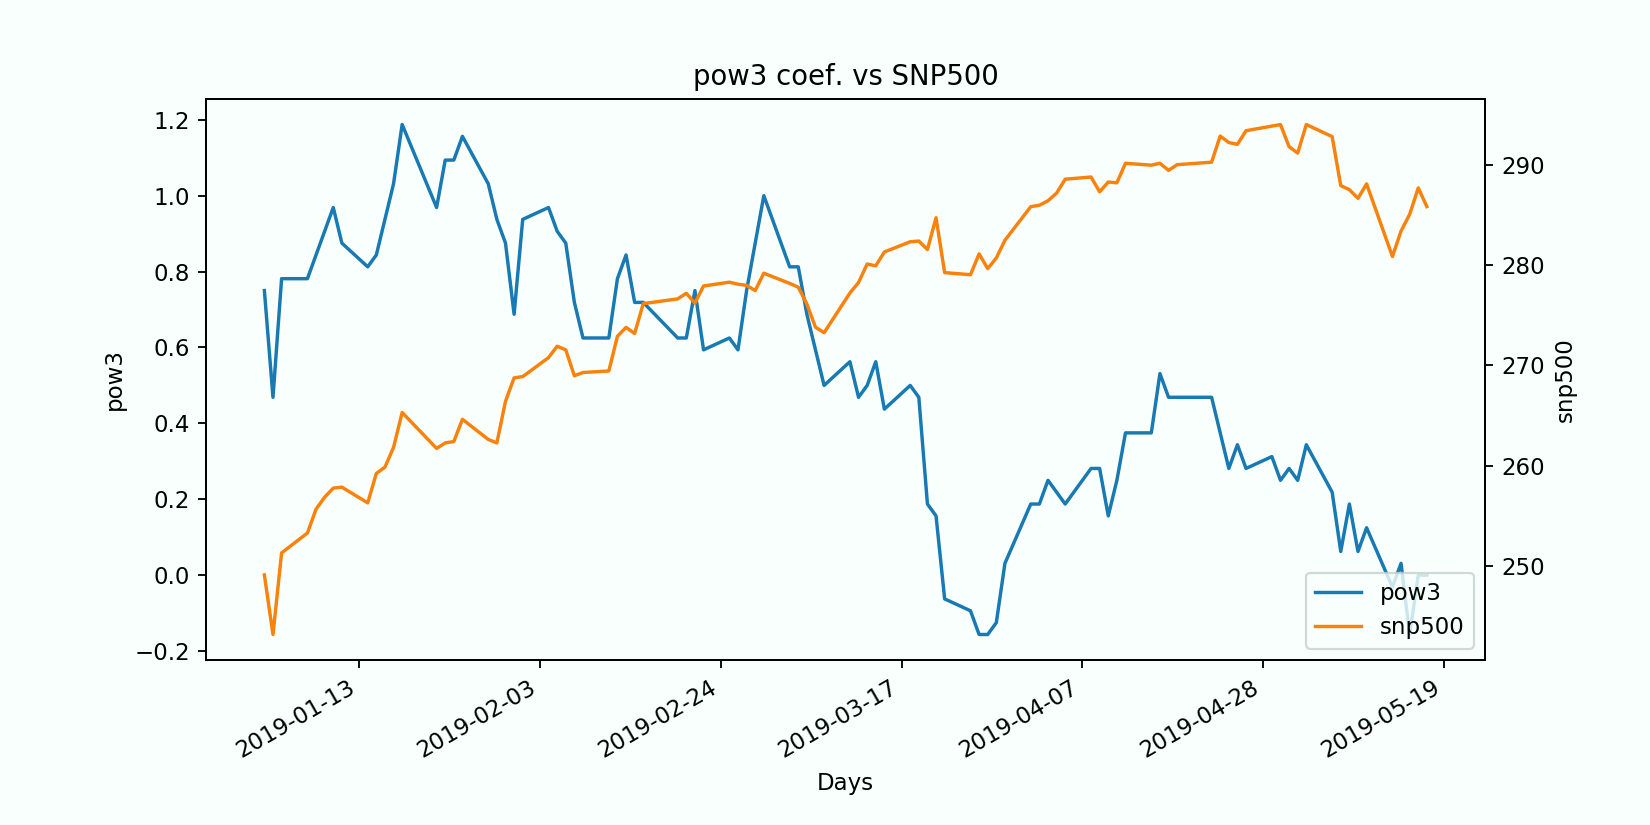

In [31]:
common.plot_multi(poly_coef_vs_snp500[['pow3','snp500']],title='pow3 coef. vs SNP500',loc='lower right', figsize=(10, 5))

<IPython.core.display.Javascript object>


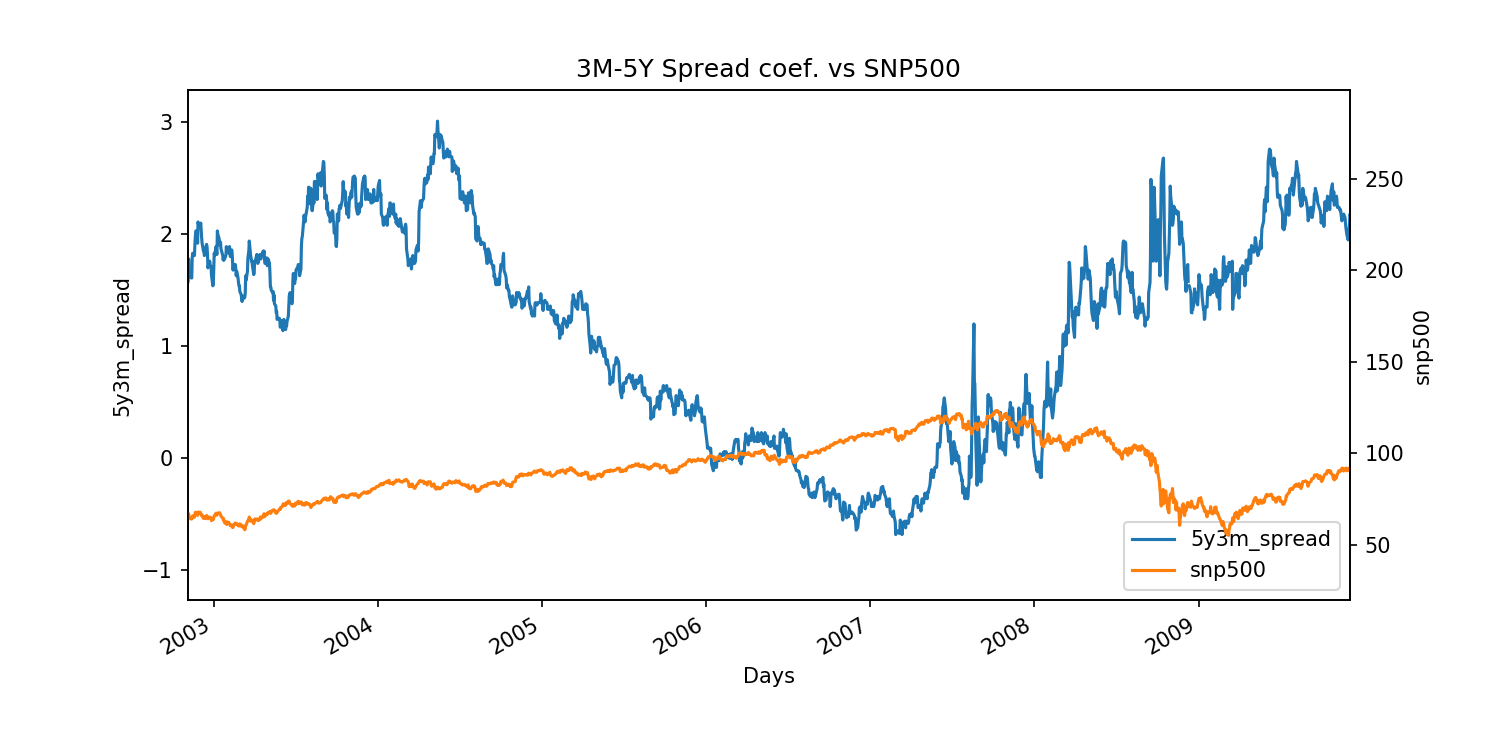

In [74]:
plot_multi(tresdf_vs_snp500[['5y3m_spread','snp500']],title='3M-5Y Spread coef. vs SNP500',loc='lower right', figsize=(10, 5))

In [34]:
plot_multi(poly_coef_vs_snp500[['pow2','pow3']],title='pow2 coef. vs pow3',loc='lower right', figsize=(10, 5))

NameError: name 'plot_multi' is not defined

<IPython.core.display.Javascript object>


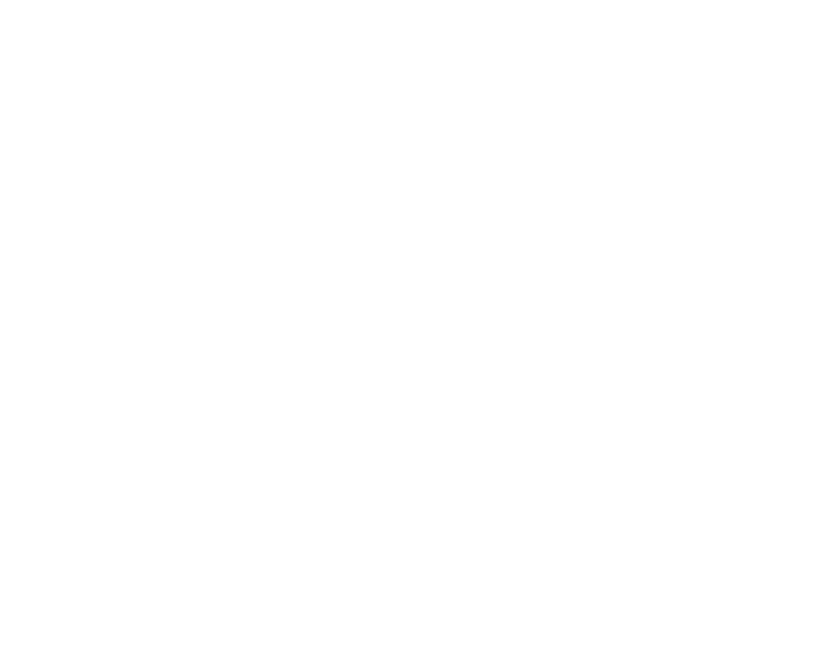

In [33]:
def animate(n,nframe):
      plt.cla()
      
      plt.plot(x, tresdf.iloc[n], '.', curve_data_t.columns.values, curve_data_t.ix[n], '-')
      plt.ylim(2.0,3)
      plt.xlim(-3,4)
      plt.text(2.4, 2.25, 'x=-2 - 3mo\nx=0 - 5y\nx=2 - 10y')
      plt.xlabel('Maturity')
      plt.ylabel('Yield')
      plt.title('Date:'+sldf.iloc[n].name+'\nShape coef.: '+str(poly_param.iloc[n,4])
               )
      font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    
fig = plt.figure(figsize=(5,4))  

anim = animation.FuncAnimation(fig, animate
                             #  , frames=22
                               ,fargs=())